In [2]:
# Imports
import math as m
import numpy as np

# Set default values for K, I, and the maximum n value
K_norm = 30

I_norm = 1e9

n_max = 20000


# Prime sieve is an efficient way to find all the primes up to (and including) n
def prime_sieve(maximum=n_max):

    # There are no primes less than 2
    if maximum < 2:
        return None

    # Will create a list of True or False values corresponding to whether the index is a prime number
    # e.g. 3 is a prime number so the value in the 3rd index (4th position) will be true by the end of the function
    prime_mask = [True for _ in range(maximum+1)]

    # 0 and 1 are not prime
    prime_mask[0], prime_mask[1] = False, False

    # Only need to check up to root n
    for p in range(2, int(m.sqrt(maximum)) + 1):
        if prime_mask[p]:
            # go over multiples of each prime number, which will not be prime, and so set value in prime_mask to False
            for i in range(p*p, maximum+1, p):
                prime_mask[i] = False

    # change prime_mask into a numpy array so we can use a boolean mask
    prime_mask = np.array(prime_mask)

    # generate the array of numbers up to n and apply boolean mask to create array of prime numbers
    return np.array([i for i in range(maximum+1)])[prime_mask]

# PRIMES calculated using prime sieve up to the largest n we are going up to, divided by 2
# We can stop here as n cannot have a prime factor larger than n/2
# this can then be used to calculate s(n) for ALL the ns up to n_max, instead of prime_sieve being called for every n
def get_primes(n=n_max):

    try:
        with open('primes.txt', 'r') as f:

            lines = f.readlines()
            n_cached = lines[0]
            primes = [int(p) for p in lines[1:]]

        if n_cached < n:
            primes.append(prime_sieve())

    except FileNotFoundError:
        primes = prime_sieve(int(n/2) + 1)



    return primes


PRIMES = get_primes()

# Using the PRIMES list get the prime factors of a umber n
def get_prime_factors(n):

    primes = PRIMES

    # create an empty dictionary of prime factors
    # we will store this is prime : exponent pairs
    # e.g. n=12 will have prime_factors = {2 : 2, 3 : 1} as 12 = 2^2 x 3
    prime_factors = {}

    # go through each prime to check if it's a divisor of n
    for prime in primes:

        # Only need to check primes up to root n
        # There may be 1 prime bigger than root n,we will deal with this at the end
        if prime**2 > n:
            break

        # check if prime divides n and add to dictionary if it does
        if n % prime == 0:
            prime_factors[int(prime)] = 1

            # now we set n to n / prime so we dont count the same prime factor more than once
            n = n / prime

            # check if this new n is still divisible by the same prime.
            # For as long as it works keep increasing the exponent value assigned to the prime, and dividing n
            while n % prime == 0:
                prime_factors[int(prime)] += 1
                n = n / prime

        # if n reaches 1 we can stop early as we know we have found the prime factorisation of n
        if n == 1:
            break

    # now we check for the potential prime factor bigger than root n.
    # If we have checked all the primes up to root n and still haven't found all the prime factors,
    # we must be left with the last prime factor as n
    if n > 1:
        prime_factors[int(n)] = 1

    # return our completed list of prime factors
    return prime_factors


# Calculate s(n)
def s(n):

    # 1 has no proper divisors
    if n == 1:
        return 0

    # the following uses the formula: (insert in latex later)
    # to calculate the sum of all the factors of n using only its prime factors
    total = 1

    primes = get_prime_factors(n).items()

    for prime, power in primes:
        total *= (prime**(power+1) - 1)/(prime - 1)

    # return s(n)
    return total - n


# Calculate the aliquot sequence of n
def aliq_seq(n, K=K_norm, I=I_norm):

    # n will be the first element of its aliquot sequence
    seq = [n]

    # make an empty set to record all the s(n)s in order to detect loops
    seen = set()

    curr_n = n
    # loop max k times to compute and check each s(n)
    # return always ends the function so no more code will run after one of the checks is 'failed'
    for k in range(K - 1):

        # check if sequence is terminated
        if curr_n == 0:
            return seq, 'terminated'

        # check if number is bigger than specified i
        if curr_n >= I:
            return seq, 'I reached'

        # check if sequence has looped
        if curr_n in seen:
            return seq, 'looped'

        # add n to sequence of seen numbers
        # has to be done after checks otherwise it will always think it loops
        seen.add(curr_n)

        # calculate next term of sequence if n has 'passed' all tests
        curr_n = s(curr_n)
        seq.append(int(curr_n))

    # If loop finished and has computed all k s(n), the sequence is finished (up to where we have decided to stop)
    # so returns sequence and the status that k has been reached
    return seq, 'K reached'


# make dictionary to count the number of types of each sequence
counts = {'terminated': 0, 'looped': 0, 'I reached': 0, 'K reached': 0}

# generate sequences up to 20000 (or whatever n_max is) and update counts dictionary
for i in range(1, n_max + 1):
    status = aliq_seq(i)[1]
    counts[status] += 1

# output counts (for testing)
print(counts)

{'terminated': 15490, 'looped': 446, 'I reached': 736, 'K reached': 3328}


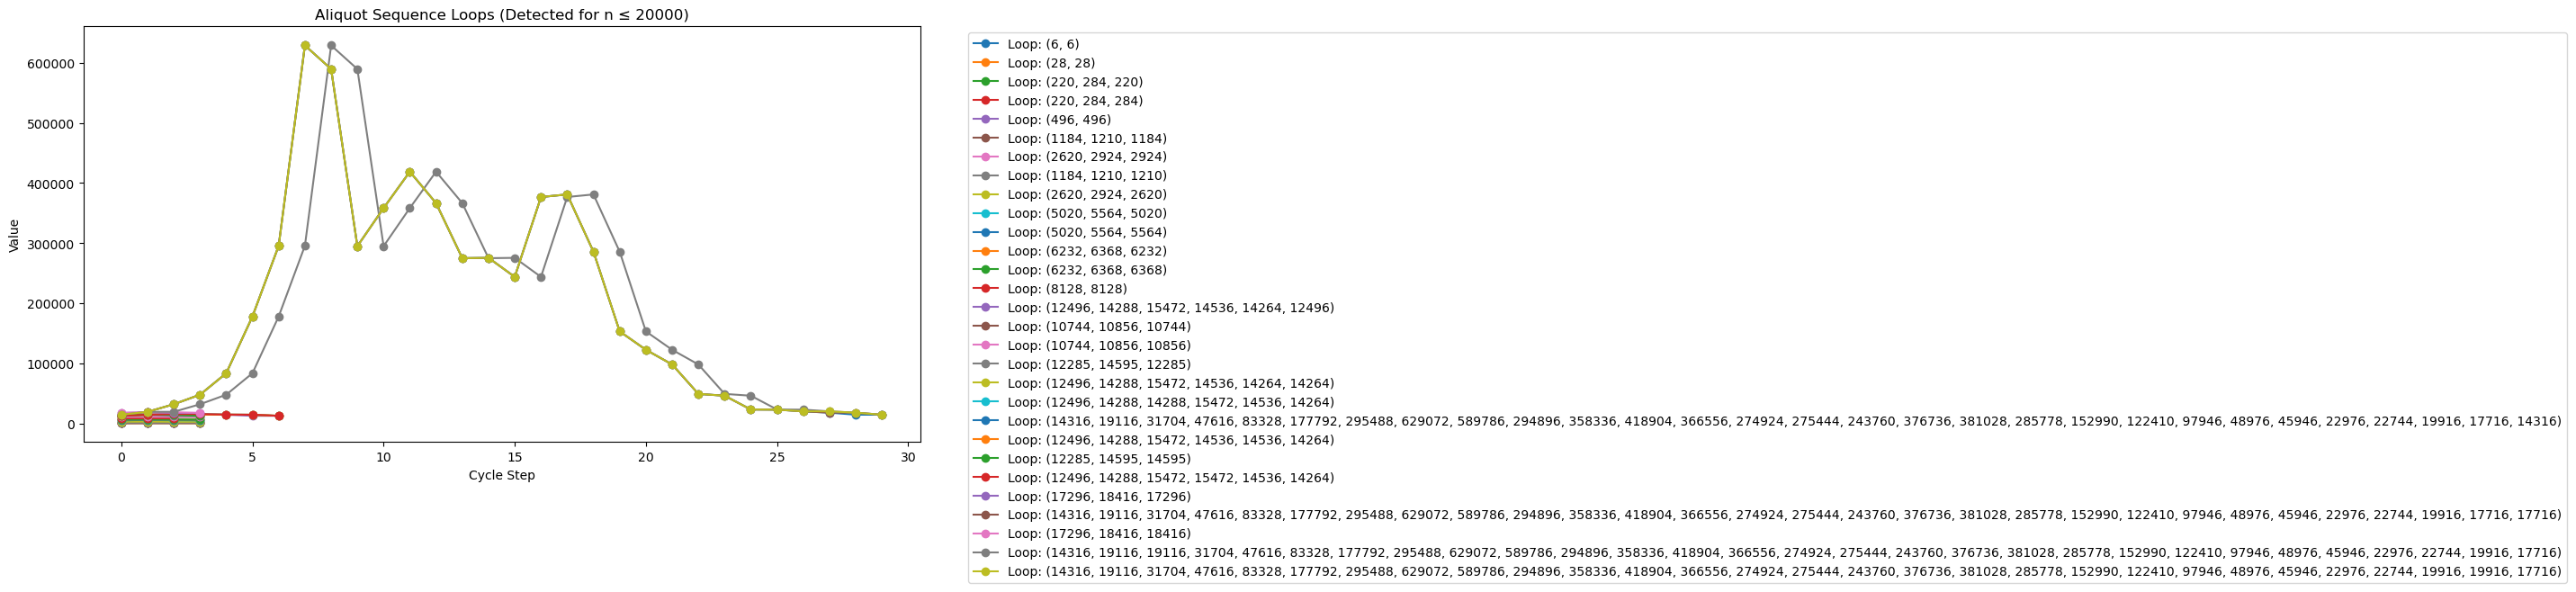

In [3]:
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Find and plot all aliquot sequences which enter loops
# --------------------------------------------------------

loop_cycles = {}          # key: smallest element of loop, value: loop list
colours = plt.cm.tab10    # colour map for repeating colours

for start in range(1, n_max + 1):
    seq, status = aliq_seq(start)
    if status == "looped":

        # find start of loop
        last = seq[-1]
        idx = seq.index(last)

        loop = seq[idx:]       # extract the cycle
        loop_tuple = tuple(loop)

        # normalise so that the same loop isn't repeated in different rotations
        min_index = loop.index(min(loop))
        normalized_loop = tuple(loop[min_index:] + loop[:min_index])

        loop_cycles[normalized_loop] = normalized_loop


# --------------------------------------------------------
# Plot loop cycles
# --------------------------------------------------------

plt.figure(figsize=(12, 6))

for i, loop in enumerate(loop_cycles.values()):
    colour = colours(i % 10)

    # Close cycle visually by joining last → first
    xs = list(range(len(loop) + 1))
    ys = loop + (loop[0],)

    plt.plot(xs, ys, marker='o', color=colour, label=f"Loop: {loop}")

plt.title("Aliquot Sequence Loops (Detected for n ≤ {})".format(n_max))
plt.xlabel("Cycle Step")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


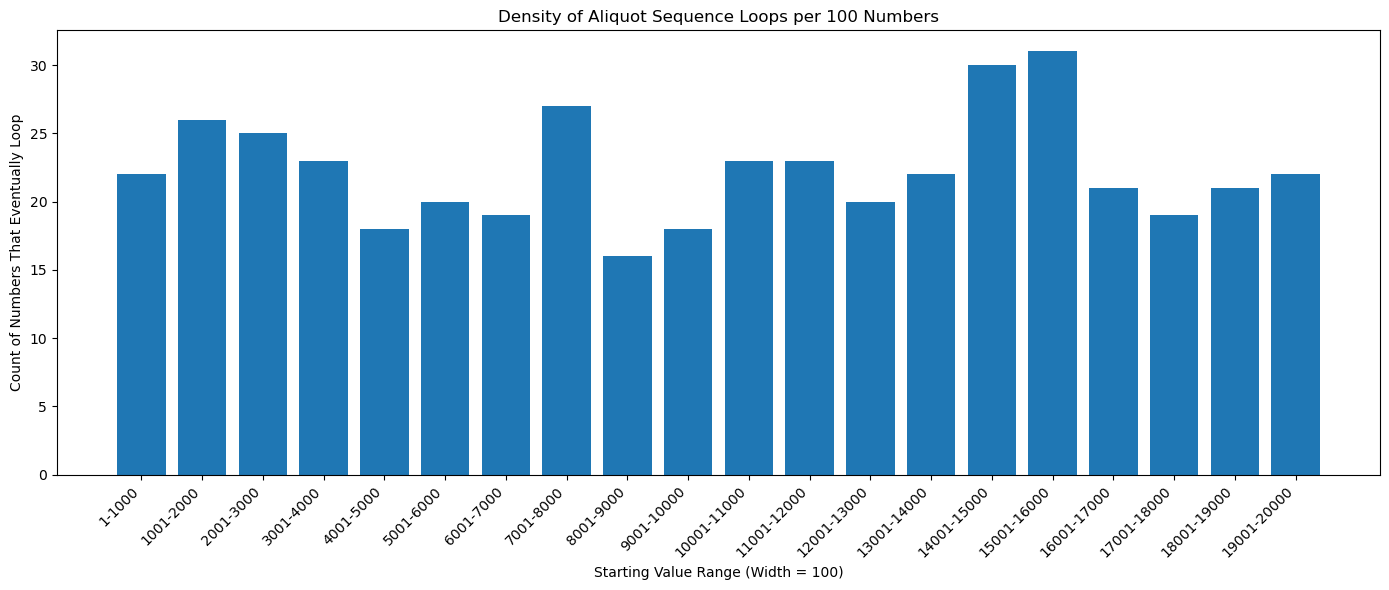

In [30]:
# --------------------------------------------------------
# Compute density (counts) of loop-starting numbers per 100-wide band
# --------------------------------------------------------

band_width = 1000
num_bands = n_max // band_width

loop_counts = np.zeros(num_bands, dtype=int)

for start in range(1, n_max + 1):
    seq, status = aliq_seq(start)
    if status == "looped":
        band_index = (start - 1) // band_width
        loop_counts[band_index] += 1

# --------------------------------------------------------
# Plot the bar graph
# --------------------------------------------------------

import matplotlib.pyplot as plt

bands = [f"{i*band_width+1}-{(i+1)*band_width}" for i in range(num_bands)]

plt.figure(figsize=(14, 6))
plt.bar(range(num_bands), loop_counts)

plt.xticks(range(num_bands), bands, rotation=45, ha='right')
plt.xlabel("Starting Value Range (Width = 100)")
plt.ylabel("Count of Numbers That Eventually Loop")
plt.title("Density of Aliquot Sequence Loops per 100 Numbers")
plt.tight_layout()
plt.show()


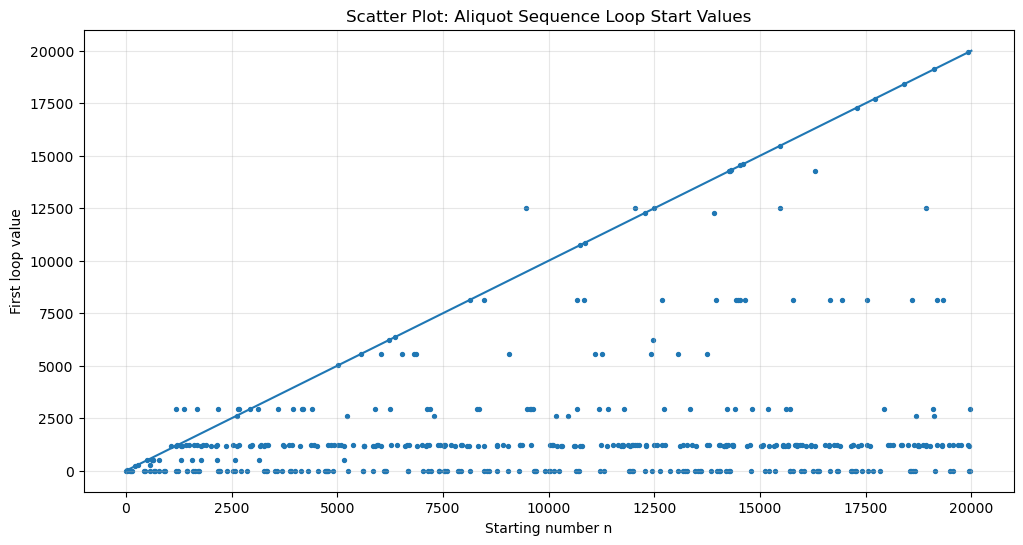

In [26]:
import matplotlib.pyplot as plt

# Collect (start_n, first_loop_number)
loop_starts = []

for n in range(1, n_max + 1):
    seq, status = aliq_seq(n)
    if status == 'looped':

        # Detect the first loop value
        seen = {}
        for i, val in enumerate(seq):
            if val in seen:             # first repeated point = start of cycle
                loop_start_value = val
                break
            seen[val] = i

        loop_starts.append((n, loop_start_value))

# Convert to lists for plotting
starts = [p[0] for p in loop_starts]
loop_vals = [p[1] for p in loop_starts]

# Scatter plot
plt.figure(figsize=(12,6))
plt.scatter(starts, loop_vals, s=8)    # small dots look cleaner
plt.xlabel("Starting number n")
plt.ylabel("First loop value")
plt.title("Scatter Plot: Aliquot Sequence Loop Start Values")
plt.grid(True, alpha=0.3)

#line of best fit
x = np.linspace(0, 20000, 20000)
y = x 
plt.plot(x, y)


plt.show()


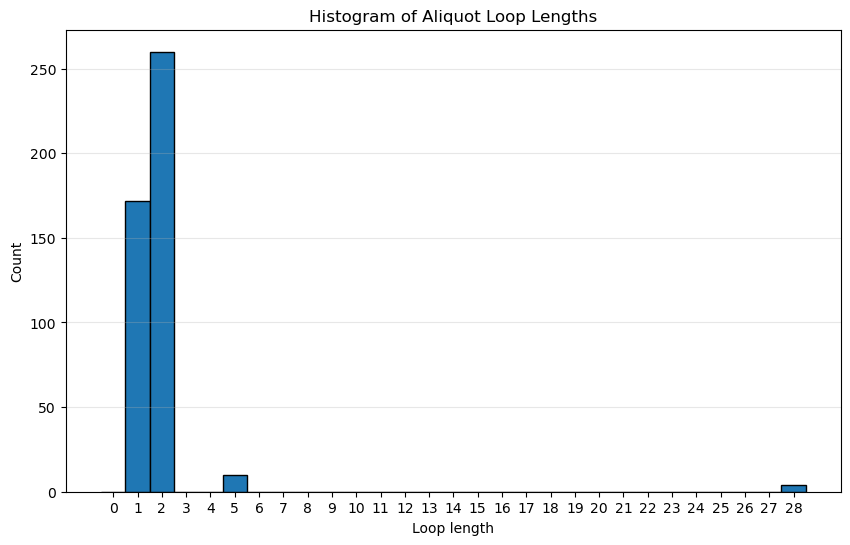

In [28]:
import matplotlib.pyplot as plt

# List to store adjusted cycle lengths
loop_lengths = []

for n in range(1, n_max + 1):
    seq, status = aliq_seq(n)
    if status == 'looped':

        # Find first repeated index
        seen = {}
        loop_start_index = None

        for i, val in enumerate(seq):
            if val in seen:
                loop_start_index = seen[val]
                break
            seen[val] = i

        # Extract loop
        loop_cycle = seq[loop_start_index:]
        loop_length = len(loop_cycle) - 1

        # Store loop_length 
        loop_lengths.append(loop_length)

# ---- Plotting histogram ----
plt.figure(figsize=(10,6))

# histogram bins: from 0 up to max length
plt.hist(loop_lengths, 
         bins=range(0, max(loop_lengths)+2), 
         edgecolor='black', 
         align='left')

plt.xlabel("Loop length")
plt.ylabel("Count")
plt.title("Histogram of Aliquot Loop Lengths")
plt.xticks(range(0, max(loop_lengths)+1))
plt.grid(axis='y', alpha=0.3)

plt.show()


In [33]:
# Dictionary:
#   loop_length → set of canonical loop tuples
loops_by_length = {}

for n in range(1, n_max + 1):
    seq, status = aliq_seq(n)

    if status == 'looped':

        # --- Find loop start ---
        seen = {}
        for i, val in enumerate(seq):
            if val in seen:
                loop_start = seen[val]
                break
            seen[val] = i

        # --- Extract ONLY the loop portion ---
        loop_cycle = seq[loop_start:]          # raw loop from seq
        loop_cycle = tuple(loop_cycle)         # convert to tuple


        # --- Store by loop length ---
        L = len(loop_cycle)

        if L not in loops_by_length:
            loops_by_length[L] = set()

        loops_by_length[L].add(loop_cycle)

# ---- Print loops sorted by length ----
print("\nALL ALIQUOT LOOPS SORTED BY LENGTH:\n")

for L in sorted(loops_by_length.keys()):
    print(f"Loop length {L}:")
    for loop in sorted(loops_by_length[L]):
        print("  ", loop)
    print()



ALL ALIQUOT LOOPS SORTED BY LENGTH:

Loop length 2:
   (6, 6)
   (28, 28)
   (496, 496)
   (8128, 8128)

Loop length 3:
   (220, 284, 220)
   (284, 220, 284)
   (1184, 1210, 1184)
   (1210, 1184, 1210)
   (2620, 2924, 2620)
   (2924, 2620, 2924)
   (5020, 5564, 5020)
   (5564, 5020, 5564)
   (6232, 6368, 6232)
   (6368, 6232, 6368)
   (10744, 10856, 10744)
   (10856, 10744, 10856)
   (12285, 14595, 12285)
   (14595, 12285, 14595)
   (17296, 18416, 17296)
   (18416, 17296, 18416)

Loop length 6:
   (12496, 14288, 15472, 14536, 14264, 12496)
   (14264, 12496, 14288, 15472, 14536, 14264)
   (14288, 15472, 14536, 14264, 12496, 14288)
   (14536, 14264, 12496, 14288, 15472, 14536)
   (15472, 14536, 14264, 12496, 14288, 15472)

Loop length 29:
   (14316, 19116, 31704, 47616, 83328, 177792, 295488, 629072, 589786, 294896, 358336, 418904, 366556, 274924, 275444, 243760, 376736, 381028, 285778, 152990, 122410, 97946, 48976, 45946, 22976, 22744, 19916, 17716, 14316)
   (17716, 14316, 19116, 3170